# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Importing Libraries

In [1]:

import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor


### Load Data and Resample by One Hour

In [2]:
# Loading data
taxi_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
# Sort index asc
taxi_data.sort_index(inplace=True)
 # hourly sum of orders
taxi_data = taxi_data.resample('1H').sum() 
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [3]:

print("Dataset shape:", taxi_data.shape)
print("Date range:", taxi_data.index.min(), "to", taxi_data.index.max())
print("Missing values:", taxi_data.isnull().sum())
print("Basic statistics:")
print(taxi_data.describe())


Dataset shape: (4416, 1)
Date range: 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Missing values: num_orders    0
dtype: int64
Basic statistics:
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


## Analysis

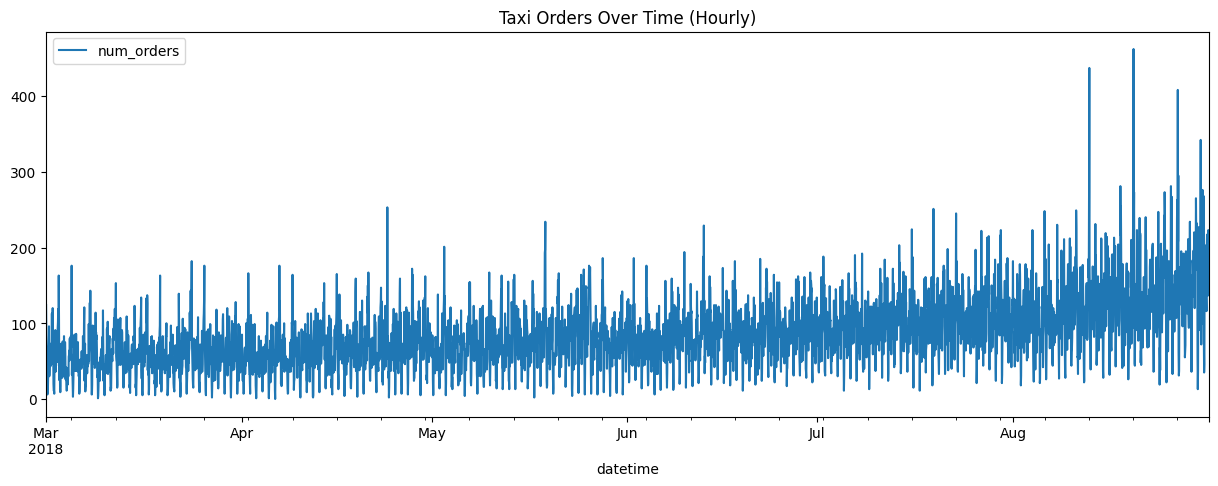

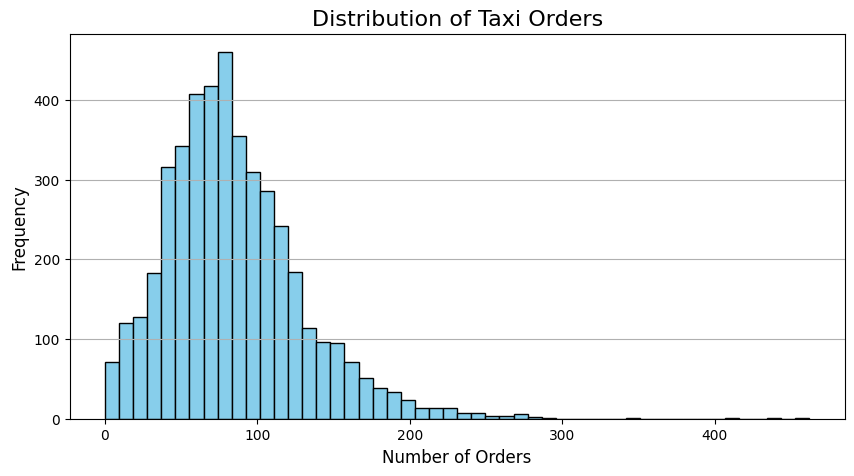

In [4]:


# Data Visualization
taxi_data.plot(figsize=(15,5))
plt.title("Taxi Orders Over Time (Hourly)")
plt.show()


plt.figure(figsize=(10,5))
plt.hist(taxi_data['num_orders'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Taxi Orders", fontsize=16)
plt.xlabel("Number of Orders", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y')
plt.show()



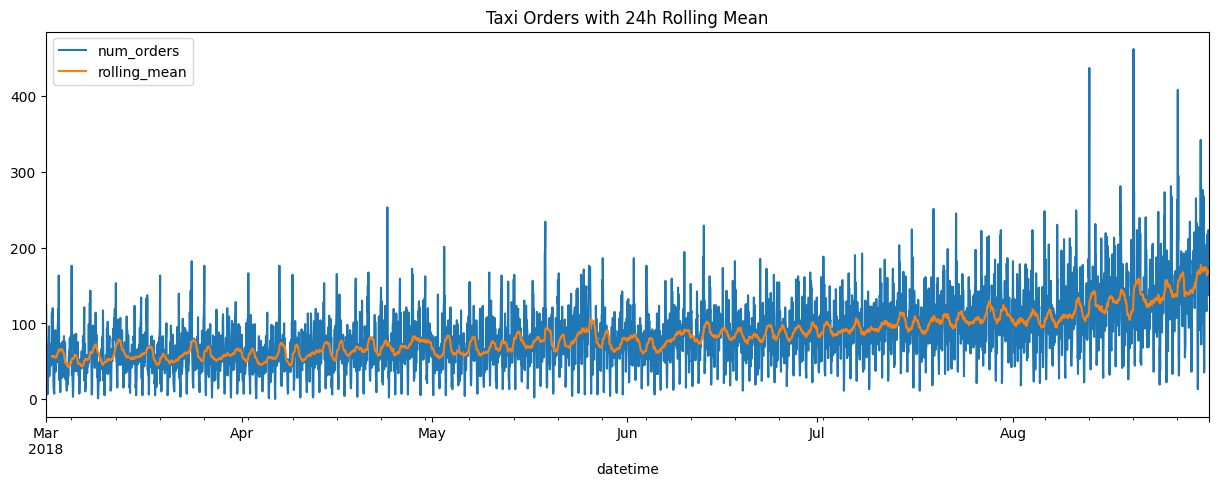

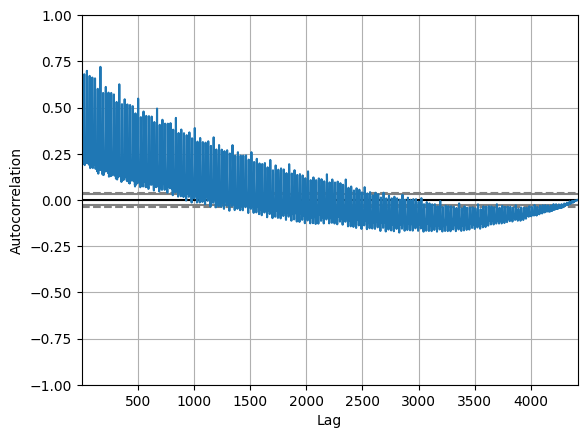

In [5]:
# Rolling mean & std
taxi_data['rolling_mean'] = taxi_data['num_orders'].rolling(24).mean()
taxi_data['rolling_std'] = taxi_data['num_orders'].rolling(24).std()

taxi_data[['num_orders','rolling_mean']].plot(figsize=(15,5))
plt.title("Taxi Orders with 24h Rolling Mean")
plt.show()

autocorrelation_plot(taxi_data['num_orders'])
plt.show()

## Training

In [6]:


training_set_to_split, test_set = train_test_split(taxi_data,shuffle=False,test_size=0.10)
# Remove NaN values BEFORE second split 
training_set_to_split = training_set_to_split.dropna()
training_set, validation_set = train_test_split(training_set_to_split,shuffle=False,test_size=0.10)
print("Training rows:", training_set.shape[0])
print("Validation rows:", validation_set.shape[0])
print("Test rows:", test_set.shape[0])

print("\nTraining range:", training_set.index.min(), "-", training_set.index.max())
print("Validation range:", validation_set.index.min(), "-", validation_set.index.max())
print("Test range:", test_set.index.min(), "-", test_set.index.max())



Training rows: 3555
Validation rows: 396
Test rows: 442

Training range: 2018-03-01 23:00:00 - 2018-07-28 01:00:00
Validation range: 2018-07-28 02:00:00 - 2018-08-13 13:00:00
Test range: 2018-08-13 14:00:00 - 2018-08-31 23:00:00


In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

# Concatenate full data for feature creation
full_data = pd.concat([training_set, validation_set, test_set])

full_features = make_features(full_data, max_lag=48, rolling_mean_size=24)

# Split back into train/valid/test using .loc
train = full_features.loc[training_set.index].dropna()
valid = full_features.loc[validation_set.index].dropna()
test  = full_features.loc[test_set.index].dropna()


# Features and target
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [8]:

# For linear regression use only
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)

# Transform validation features
features_valid_scaled = scaler.transform(features_valid)

## Testing

### Linear Regression Model

In [9]:


%%time
lr = LinearRegression()
lr.fit(features_train_scaled, target_train)
# Predict on VALIDATION data only
target_pred_lr_valid = lr.predict(features_valid_scaled)
# Compute RMSE on VALIDATION set
rmse_lr_valid = mean_squared_error(target_valid, target_pred_lr_valid, squared=False)
print("Linear Regression VALIDATION RMSE:", rmse_lr_valid)


Linear Regression VALIDATION RMSE: 30.874437069886028
CPU times: user 19.9 ms, sys: 34 ms, total: 54 ms
Wall time: 9.83 ms


### Random Forest Model

In [10]:

%%time
# Define Random Forest
rf = RandomForestRegressor(random_state=12345)

# Hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search using TRAIN + VALIDATION split only
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,  # cross-validation on training only
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit on training set
grid_search_rf.fit(features_train, target_train)

# Evaluate on VALIDATION set only
target_pred_rf_valid = grid_search_rf.predict(features_valid)
rmse_rf_valid = mean_squared_error(target_valid, target_pred_rf_valid, squared=False)

print("RandomForest Best Parameters (from CV):", grid_search_rf.best_params_)
print("RandomForest VALIDATION RMSE:", rmse_rf_valid)

RandomForest Best Parameters (from CV): {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest VALIDATION RMSE: 32.2389612395527
CPU times: user 13.7 s, sys: 149 ms, total: 13.8 s
Wall time: 3min 54s


### CatBoost Model

In [11]:
%%time
cat = CatBoostRegressor(loss_function='RMSE', verbose=0, random_state=12345)

param_grid_cat = {
    'depth': [3,4,5],
    'learning_rate': [0.01,0.05,0.1],
    'iterations': [50,100,200],
    'early_stopping_rounds':[50]
}

grid_search_cat = GridSearchCV(
    cat,
    param_grid_cat,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_cat.fit(features_train, target_train)
target_pred_cat = grid_search_cat.predict(features_valid)
rmse_cat = mean_squared_error(target_valid, target_pred_cat, squared=False)

print("CatBoost Best Parameters:", grid_search_cat.best_params_)
print("CatBoost valid RMSE:", rmse_cat)


CatBoost Best Parameters: {'depth': 5, 'early_stopping_rounds': 50, 'iterations': 200, 'learning_rate': 0.1}
CatBoost valid RMSE: 30.092030614692643
CPU times: user 2.21 s, sys: 72.7 ms, total: 2.28 s
Wall time: 34.9 s


### LightGBM Model

In [12]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=12345)

param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01,0.05,0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, -1]
}

grid_search_lgb = GridSearchCV(
    lgb_model,
    param_grid_lgb,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_lgb.fit(features_train, target_train)
target_pred_lgb = grid_search_lgb.predict(features_valid)
rmse_lgb = mean_squared_error(target_valid, target_pred_lgb, squared=False)

print("LightGBM Best Parameters:", grid_search_lgb.best_params_)
print("LightGBM validation RMSE:", rmse_lgb)

LightGBM Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 31}
LightGBM validation RMSE: 29.87917497041818
CPU times: user 5.73 s, sys: 44.1 ms, total: 5.77 s
Wall time: 1min 59s


### Dummy Model

In [13]:

# Initialize DummyRegressor
dummy = DummyRegressor(strategy='mean')

# Fit on training data
dummy.fit(features_train, target_train)

# Predict on test data
target_pred_dummy = dummy.predict(features_test)

# Evaluate RMSE
rmse_dummy = mean_squared_error(target_test, target_pred_dummy, squared=False)
print("Dummy Regressor Test RMSE:", rmse_dummy)


Dummy Regressor Test RMSE: 87.0552397909285


### Best Model

In [14]:
# LightGBM as it was the lowest one
target_pred_lgb_test = grid_search_lgb.predict(features_test)
rmse_lgb_test = mean_squared_error(target_test, target_pred_lgb_test, squared=False)
print("LightGBM FINAL TEST RMSE:", rmse_lgb_test)


LightGBM FINAL TEST RMSE: 46.903196211565024


### Conclusion

Since the data spans from March 1st to August 31st and I split the test set with the last 10 percent of the data in chronological order, hyperparemeter tuning was definitly needed in order to achieve desired RSME. I also tried several lag and rolling mean values and ultimately decided to go with 48,24 respectively to capture daily trends as well as potential patterns in the weekends. Overall, the best model was the LightGBM model and it had an RSME of 46.9

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48